<a href="https://colab.research.google.com/github/eeuuais/studypolio/blob/main/Pytorch_prac/(pytorch)mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Network로 다시 풀어보는 MNST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Train, test 용도 데이터 선택

train_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=True,
                               transform=transforms.ToTensor(),
                               )

test_dataset = datasets.MNIST('./mnist_data',
                               download=False,
                               train=False,
                               transform=transforms.ToTensor(),
                               )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [6]:
# dataset 로더 호출

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=False)

In [7]:
# 장치 호출
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# cnn 모델 생성
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5,1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5,1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.lin1 = nn.Linear(16*4*4,96)
        self.drop1 = nn.Dropout(0.2)
        self.lin2 = nn.Linear(96,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.drop1(self.lin1(x)))
        x = F.softmax(self.lin2(x)) # nn.CrossEntropyLoss를 사용하려면 x=self.lin2(x)
        return x

In [14]:
# 확률간 거리 Kullback-Leibler divergence
def kl_div(prob1,prob2):
    '''
    prob1: label
    prob2: inference
    '''
    return torch.sum(prob1*torch.log(prob1/prob2+1e-15))

In [15]:
model = CNN_MNIST().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-04)

 
#criterion = nn.CrossEntropyLoss()으로도 이용 가능
for ep in range(20):
    model.train()
    train_loss = 0
    for X,Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        # One-hot encoding --> criterion이용하려면 사용금지
        Y_label = torch.zeros((Y.shape[0],10)).to(device)
        Y_label[range(Y.shape[0]),Y]=1
        
        Y_infer = model(X)
        loss = kl_div(Y_label,Y_infer)
        #loss = criterion(Y_infer,Y_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    test_loss = 0
    for X,Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        Y_label = torch.zeros((Y.shape[0],10)).to(device)
        Y_label[range(Y.shape[0]),Y]=1
        
        Y_infer = model(X)
        loss = kl_div(Y_label,Y_infer)
        
        test_loss += loss.item()
        
    if ep % 5 == 0:
        print('Episode {:d}, Train_loss {:.3f}, Test_loss {:.3f}'
              .format(ep,train_loss/len(train_loader),test_loss/len(test_loader)))

<ipython-input-13-7500c563961a>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.lin2(x)) # nn.CrossEntropyLoss를 사용하려면 x=self.lin2(x)


Episode 0, Train_loss 164.403, Test_loss 60.063
Episode 5, Train_loss 27.046, Test_loss 19.940
Episode 10, Train_loss 16.819, Test_loss 12.071
Episode 15, Train_loss 12.497, Test_loss 9.092


In [16]:
model.eval()
correct = 0
for X, Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_infer = model(X)
    correct += np.mean(torch.argmax(Y_infer, dim=1).detach().cpu().numpy()==Y.detach().cpu().numpy())

print("테스트 데이터 정확도: {:.4f}%"
      .format(100.0 * correct / len(test_loader)))

<ipython-input-13-7500c563961a>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.lin2(x)) # nn.CrossEntropyLoss를 사용하려면 x=self.lin2(x)


테스트 데이터 정확도: 98.0716%


실제 이미지 숫자 7
예측 숫자 7


<ipython-input-13-7500c563961a>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.lin2(x)) # nn.CrossEntropyLoss를 사용하려면 x=self.lin2(x)


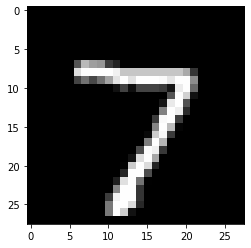

In [17]:
# Checking

X, Y = test_dataset[0]
X = X.to(device)
Y_infer = model(torch.unsqueeze(X,0))

print('실제 이미지 숫자', Y)
print('예측 숫자', np.argmax(Y_infer.detach().cpu().numpy()))
plt.imshow(X.detach().cpu().numpy()[0], cmap='gray')